<a href="https://colab.research.google.com/github/hamzaq453/Langchain-learnings/blob/main/Agent_with_Memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install -q -U langchain_google_genai langchain_core langgraph


In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# Set up the Gemini API key
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

# Initialize the LLM
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)


In [27]:
# Tool 1: Add
def add(a: int, b: int) -> int:
    """
    Adds two numbers.
    Args:
        a (int): First number.
        b (int): Second number.
    Returns:
        int: Sum of a and b.
    """
    return a + b

# Tool 2: Multiply
def multiply(a: int, b: int) -> int:
    """
    Multiplies two numbers.
    Args:
        a (int): First number.
        b (int): Second number.
    Returns:
        int: Product of a and b.
    """
    return a * b

# Tool 3: Divide
def divide(a: int, b: int) -> float:
    """
    Divides two numbers.
    Args:
        a (int): Numerator.
        b (int): Denominator.
    Returns:
        float: Quotient of a and b.
    """
    if b == 0:
        raise ValueError("Division by zero is not allowed.")
    return a / b

# Bind the tools to the LLM
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)


In [28]:
# System message for the assistant
sys_msg = SystemMessage(content="You are a helpful assistant that performs arithmetic operations.")

# Assistant node
def assistant(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


In [29]:
# Initialize memory checkpointer
memory = MemorySaver()

# Build the graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,  # Route to tools if a tool call is detected
)
builder.add_edge("tools", "assistant")  # Loop back to assistant
builder.add_edge("assistant", END)  # End if no tool call is detected

# Compile the graph with memory
react_graph_memory = builder.compile(checkpointer=memory)


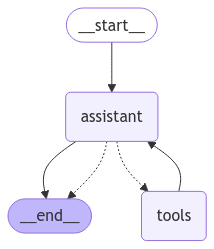

In [30]:
# Display the graph structure
display(Image(react_graph_memory.get_graph(xray=True).draw_mermaid_png()))


In [31]:
# Specify thread ID for persistent memory
config1 = {"configurable": {"thread_id": "1"}}

# First interaction
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph_memory.invoke({"messages": messages}, config1)

# Display the response
for msg in messages['messages']:
    msg.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (21d82eb1-c035-4673-a8eb-7058a0c724ae)
 Call ID: 21d82eb1-c035-4673-a8eb-7058a0c724ae
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [32]:
# Second interaction in the same thread
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config1)

# Display the response
for msg in messages['messages']:
    msg.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (21d82eb1-c035-4673-a8eb-7058a0c724ae)
 Call ID: 21d82eb1-c035-4673-a8eb-7058a0c724ae
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (4806fbaf-35ef-4536-ace2-7578d4a6d067)
 Call ID: 4806fbaf-35ef-4536-ace2-7578d4a6d067
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message =====================

In [34]:
# Second interaction in the same thread
messages = [HumanMessage(content="Add 2 in the result")]
messages = react_graph_memory.invoke({"messages": messages}, config1)

# Display the response
for msg in messages['messages']:
    msg.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (21d82eb1-c035-4673-a8eb-7058a0c724ae)
 Call ID: 21d82eb1-c035-4673-a8eb-7058a0c724ae
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (4806fbaf-35ef-4536-ace2-7578d4a6d067)
 Call ID: 4806fbaf-35ef-4536-ace2-7578d4a6d067
  Args:
    a: 7.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message =====================